# Phase 3: Modeling & Explainability

This notebook explores the modeling process for the Telco Customer Churn dataset, focusing on:

1. **Baseline Models**: Establishing baseline performance with logistic regression
2. **Advanced Models**: Training and comparing XGBoost and LightGBM models
3. **Hyperparameter Tuning**: Exploring optimal hyperparameters using Optuna
4. **Model Evaluation**: Comprehensive evaluation with multiple metrics
5. **Explainability**: SHAP-based model interpretability analysis

## Objectives
- Compare different modeling approaches
- Identify the best performing model
- Understand feature importance and model behavior
- Generate insights for production deployment



In [1]:
# ============================================================================
# NOTEBOOK CONFIGURATION - Adjust these parameters to control computational load
# ============================================================================
#
# For FAANG-level development on resource-constrained machines:
# - Set N_OPTUNA_TRIALS to 1-3 for quick testing
# - Set ENABLE_SHAP to False to skip SHAP analysis (saves significant time/memory)
# - Set ENABLE_PLOTS to False to skip visualization generation
# - Set SHAP_SAMPLE_SIZE to a smaller number (e.g., 100) for faster SHAP
#
# For full exploration:
# - N_OPTUNA_TRIALS: 20-50 (default: 5 for notebook)
# - ENABLE_SHAP: True
# - ENABLE_PLOTS: True
# - SHAP_SAMPLE_SIZE: 500-1000
# ============================================================================

# Hyperparameter tuning configuration
N_OPTUNA_TRIALS = 5  # Number of Optuna trials per model (reduce to 1-3 for faster execution)
OPTUNA_TIMEOUT = 1800  # Timeout in seconds (30 minutes) - set to None for no timeout

# SHAP explainability configuration
ENABLE_SHAP = True  # Set to False to skip SHAP analysis entirely
SHAP_BACKGROUND_SAMPLE = (
    1000  # Number of samples for SHAP background (reduce to 100-500 for faster execution)
)
SHAP_EXPLANATION_SAMPLE = (
    500  # Number of test samples to explain (reduce to 100-200 for faster execution)
)

# Visualization configuration
ENABLE_PLOTS = True  # Set to False to skip all plotting (saves memory and time)
ENABLE_MODEL_COMPARISON_PLOTS = True  # Set to False to skip model comparison visualizations

# Performance monitoring
ENABLE_PERFORMANCE_CHECKS = True  # Set to False to skip latency/performance assertions

print("=" * 80)
print("NOTEBOOK CONFIGURATION")
print("=" * 80)
print(f"Optuna Trials: {N_OPTUNA_TRIALS}")
print(f"SHAP Enabled: {ENABLE_SHAP}")
print(f"SHAP Background Sample: {SHAP_BACKGROUND_SAMPLE}")
print(f"SHAP Explanation Sample: {SHAP_EXPLANATION_SAMPLE}")
print(f"Plots Enabled: {ENABLE_PLOTS}")
print(f"Performance Checks: {ENABLE_PERFORMANCE_CHECKS}")
print("=" * 80)

NOTEBOOK CONFIGURATION
Optuna Trials: 5
SHAP Enabled: True
SHAP Background Sample: 1000
SHAP Explanation Sample: 500
Plots Enabled: True
Performance Checks: True


In [ ]:
print("=" * 80)
print("INITIALIZING NOTEBOOK ENVIRONMENT")
print("=" * 80)

import os
import sys
import warnings
from pathlib import Path

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress Optuna widget outputs
os.environ["OPTUNA_DISABLE_IMPORT_WARNING"] = "1"

# Add project root to path
print("\nLocating project root...")
# Find project root by looking for 'src' directory
current_dir = Path.cwd()
PROJECT_ROOT = None

# Strategy 1: Check if current directory is project root
if (current_dir / "src").exists():
    PROJECT_ROOT = current_dir
# Strategy 2: Check if we're in notebooks/ subdirectory
elif (current_dir.parent / "src").exists():
    PROJECT_ROOT = current_dir.parent
# Strategy 3: Search up the directory tree
else:
    for parent in current_dir.parents:
        if (parent / "src").exists():
            PROJECT_ROOT = parent
            break

# Fallback: use current directory if src not found
if PROJECT_ROOT is None:
    PROJECT_ROOT = current_dir
    print(f"WARNING: Could not find 'src' directory. Using current directory: {PROJECT_ROOT}")
    print("Make sure you're running from the project root or notebooks/ directory")
else:
    print(f"[OK] Project root found: {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("\nImporting required libraries...")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For Jupyter notebook display - ensure inline backend
try:
    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic("matplotlib", "inline")
except Exception:
    # If not in IPython, try to set inline backend
    try:
        import matplotlib

        matplotlib.use("module://matplotlib_inline.backend_inline")
    except Exception:
        pass

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Import project modules
from sklearn.model_selection import train_test_split

from src.features.pipeline import apply_feature_pipeline, create_feature_pipeline
from src.models.baseline import BaselineModel
from src.models.evaluation import ModelEvaluator
from src.models.trainer import ModelTrainer, TrainingConfig

# Optional import for explainability (requires shap)
print("Checking for SHAP availability...")
try:
    from src.models.explainability import ModelExplainer

    SHAP_AVAILABLE = True
    print("[OK] SHAP available")
except ImportError:
    ModelExplainer = None  # type: ignore
    SHAP_AVAILABLE = False
    print("Note: shap not installed. ModelExplainer will not be available.")

# Suppress Optuna progress bar widgets
try:
    import optuna

    optuna.logging.set_verbosity(optuna.logging.WARNING)
except ImportError:
    pass

print("\n" + "=" * 80)
print("ENVIRONMENT INITIALIZED")
print("=" * 80)
print("\n[OK] All imports successful")
print("[OK] Notebook ready for execution")

INITIALIZING NOTEBOOK ENVIRONMENT

Locating project root...
[OK] Project root found: C:\Users\tiwar\OneDrive - The University of Melbourne\Desktop\New folder\telco-churn-retention

Importing required libraries...


Checking for SHAP availability...
[OK] SHAP available

ENVIRONMENT INITIALIZED

[OK] All imports successful
[OK] Notebook ready for execution


## 1. Load and Prepare Data


In [3]:
# ALWAYS load from raw Telco CSV data to ensure we're using the actual dataset
print("=" * 80)
print("LOADING TELCO CUSTOMER CHURN DATASET")
print("=" * 80)

from src.data.ingestion import clean_dataset, load_raw_dataset

# Load raw Telco CSV data
raw_path = PROJECT_ROOT / "data" / "raw" / "telco_data_28_11_2025.csv"

if not raw_path.exists():
    raise FileNotFoundError(f"Telco data file not found at {raw_path}")

print(f"Loading Telco data from: {raw_path}")
df = load_raw_dataset(raw_path)
print(f"Raw data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Display sample of raw data to verify it's Telco data
print("\nSample of raw Telco data (first 3 rows):")
print(df.head(3))
print(f"\nColumns in raw data: {list(df.columns)}")

# Clean the dataset
df = clean_dataset(df)
print(f"\nAfter cleaning: {df.shape[0]} rows, {df.shape[1]} columns")

# Verify we have Telco-specific columns
required_telco_cols = ["tenure", "MonthlyCharges", "TotalCharges", "Churn", "customerID"]
missing_cols = [col for col in required_telco_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required Telco columns: {missing_cols}")

print("\n[OK] Verified: All required Telco columns present")

# Prepare dataframe for pipeline (drop customerID if present)
df_for_pipeline = df.drop(columns=["customerID"]) if "customerID" in df.columns else df.copy()

# Create and apply feature pipeline
print("\nCreating features from Telco data...")
pipeline = create_feature_pipeline()
pipeline.fit(df_for_pipeline)
X, y = apply_feature_pipeline(df_for_pipeline, pipeline, target_column="Churn")

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 80)
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean():.2%}")

# Display sample feature names to verify they're from Telco data
print(f"\nSample feature names (first 10): {list(X.columns[:10])}")
print("\n[OK] Successfully loaded and processed Telco Customer Churn dataset")

LOADING TELCO CUSTOMER CHURN DATASET


Loading Telco data from: C:\Users\tiwar\OneDrive - The University of Melbourne\Desktop\New folder\telco-churn-retention\data\raw\telco_data_28_11_2025.csv
Raw data loaded: 7043 rows, 21 columns

Sample of raw Telco data (first 3 rows):
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month   

## 2. Train-Test Split


In [4]:
# Keep as DataFrames to preserve feature names (fixes sklearn warnings)
print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)

# Check for and handle NaN values
print("\nChecking for NaN values...")
nan_counts = X.isna().sum()
if nan_counts.sum() > 0:
    print(
        f"Found NaN values in {nan_counts.sum()} cells across {nan_counts[nan_counts > 0].shape[0]} features"
    )
    print("Features with NaN values:")
    print(nan_counts[nan_counts > 0])
    # Fill NaN values with median for numeric columns
    for col in X.columns:
        if X[col].isna().sum() > 0:
            if X[col].dtype in ["float64", "int64"]:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(0)
    print("\n[OK] NaN values filled")
else:
    print("[OK] No NaN values found")

# Split data
print("\nSplitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split train into train/val
print("Splitting training set into train/validation sets...")
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Store feature names for later use
feature_names = list(X.columns)

print("\n" + "=" * 80)
print("DATA SPLIT COMPLETE")
print("=" * 80)
print(f"\nTrain set: {X_train_fit.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain churn rate: {y_train_fit.mean():.2%}")
print(f"Validation churn rate: {y_val.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")
print("\n[OK] Data split completed successfully")

TRAIN-TEST SPLIT

Checking for NaN values...
[OK] No NaN values found

Splitting data into train/test sets...
Splitting training set into train/validation sets...

DATA SPLIT COMPLETE

Train set: 4507 samples
Validation set: 1127 samples
Test set: 1409 samples

Train churn rate: 26.54%
Validation churn rate: 26.53%
Test churn rate: 26.54%

[OK] Data split completed successfully


## 3. Baseline Model: Logistic Regression


In [5]:
# Train baseline model
print("=" * 80)
print("TRAINING BASELINE MODEL")
print("=" * 80)

print("\nInitializing baseline logistic regression model...")
# Baseline model expects numpy arrays
baseline_model = BaselineModel(class_weight="balanced", random_state=42, calibrate=True)

print("Training baseline model...")
baseline_model.fit(X_train_fit.values, y_train_fit.values)

print("Evaluating baseline model...")
# Evaluate baseline (convert to numpy for evaluation)
baseline_evaluator = ModelEvaluator(baseline_model, feature_names=feature_names)
baseline_metrics = baseline_evaluator.evaluate(X_test.values, y_test.values)

print("\n" + "=" * 80)
print("BASELINE MODEL TRAINING COMPLETE")
print("=" * 80)
print("\nBaseline Model Performance:")
print(f"  ROC-AUC: {baseline_metrics.roc_auc:.4f}")
print(f"  PR-AUC: {baseline_metrics.pr_auc:.4f}")
print(f"  Accuracy: {baseline_metrics.accuracy:.4f}")
print(f"  Precision: {baseline_metrics.precision:.4f}")
print(f"  Recall: {baseline_metrics.recall:.4f}")
print(f"  F1-Score: {baseline_metrics.f1:.4f}")
print("\n[OK] Baseline model trained and evaluated successfully")

TRAINING BASELINE MODEL

Initializing baseline logistic regression model...
Training baseline model...


Evaluating baseline model...

BASELINE MODEL TRAINING COMPLETE

Baseline Model Performance:
  ROC-AUC: 0.8481
  PR-AUC: 0.6668
  Accuracy: 0.8048
  Precision: 0.6689
  Recall: 0.5241
  F1-Score: 0.5877

[OK] Baseline model trained and evaluated successfully


## 4. XGBoost Model


In [6]:
# Train XGBoost model
print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)

try:
    print("\nConfiguring XGBoost model with hyperparameter tuning...")
    xgboost_config = TrainingConfig(
        model_type="xgboost",
        random_state=42,
        cv_folds=5,
        test_size=0.2,
        use_smote=False,
        calibrate=False,
        n_trials=5,  # Reduced for quick testing
        timeout=1800,  # 30 minutes
    )

    print("Initializing XGBoost trainer...")
    xgboost_trainer = ModelTrainer(xgboost_config, mlflow_experiment_name="telco_churn_notebook")

    print("Training XGBoost model (this may take a few minutes)...")
    # Trainer now handles DataFrames internally
    xgboost_model = xgboost_trainer.train(X_train_fit, y_train_fit, X_val, y_val)

    print("Evaluating XGBoost model...")
    # Evaluate XGBoost (convert to numpy for evaluation to avoid warnings)
    xgboost_evaluator = ModelEvaluator(xgboost_model, feature_names=feature_names)
    xgboost_metrics = xgboost_evaluator.evaluate(X_test.values, y_test.values)

    print("\n" + "=" * 80)
    print("XGBOOST MODEL TRAINING COMPLETE")
    print("=" * 80)
    print("\nXGBoost Model Performance:")
    print(f"  ROC-AUC: {xgboost_metrics.roc_auc:.4f}")
    print(f"  PR-AUC: {xgboost_metrics.pr_auc:.4f}")
    print(f"  Accuracy: {xgboost_metrics.accuracy:.4f}")
    print(f"  Precision: {xgboost_metrics.precision:.4f}")
    print(f"  Recall: {xgboost_metrics.recall:.4f}")
    print(f"  F1-Score: {xgboost_metrics.f1:.4f}")
    print(f"\nBest Parameters: {xgboost_trainer.best_params}")
    print("\n[OK] XGBoost model trained and evaluated successfully")
except ImportError as e:
    print(f"\n[SKIPPED] XGBoost training requires additional dependencies: {e}")
    print("Install with: pip install xgboost optuna")
    xgboost_model = None
    xgboost_evaluator = None
    xgboost_metrics = None
except Exception as e:
    print(f"\n[FAIL] Error training XGBoost model: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback

    traceback.print_exc()
    xgboost_model = None
    xgboost_evaluator = None
    xgboost_metrics = None

TRAINING XGBOOST MODEL

Configuring XGBoost model with hyperparameter tuning...
Initializing XGBoost trainer...
Training XGBoost model (this may take a few minutes)...


  0%|          | 0/5 [00:00<?, ?it/s]

2025/12/01 22:48:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/12/01 22:49:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Evaluating XGBoost model...

XGBOOST MODEL TRAINING COMPLETE

XGBoost Model Performance:
  ROC-AUC: 0.8446
  PR-AUC: 0.6528
  Accuracy: 0.7587
  Precision: 0.5305
  Recall: 0.7914
  F1-Score: 0.6352

Best Parameters: {'n_estimators': 647, 'max_depth': 4, 'learning_rate': 0.012476394272569451, 'subsample': 0.9795542149013333, 'colsample_bytree': 0.9862528132298237, 'min_child_weight': 9, 'gamma': 0.3046137691733707, 'reg_alpha': 0.002458603276328005, 'reg_lambda': 0.5456725485601477, 'scale_pos_weight': 2.480686221828206, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}

[OK] XGBoost model trained and evaluated successfully


## 5. LightGBM Model


In [7]:
# Train LightGBM model
print("=" * 80)
print("TRAINING LIGHTGBM MODEL")
print("=" * 80)

try:
    print("\nConfiguring LightGBM model with hyperparameter tuning...")
    lightgbm_config = TrainingConfig(
        model_type="lightgbm",
        random_state=42,
        cv_folds=5,
        test_size=0.2,
        use_smote=False,
        calibrate=False,
        n_trials=5,  # Reduced for quick testing
        timeout=1800,  # 30 minutes
    )

    print("Initializing LightGBM trainer...")
    lightgbm_trainer = ModelTrainer(lightgbm_config, mlflow_experiment_name="telco_churn_notebook")

    print("Training LightGBM model (this may take a few minutes)...")
    # Trainer now handles DataFrames internally
    lightgbm_model = lightgbm_trainer.train(X_train_fit, y_train_fit, X_val, y_val)

    print("Evaluating LightGBM model...")
    # Evaluate LightGBM (convert to numpy for evaluation to avoid warnings)
    lightgbm_evaluator = ModelEvaluator(lightgbm_model, feature_names=feature_names)
    lightgbm_metrics = lightgbm_evaluator.evaluate(X_test.values, y_test.values)

    print("\n" + "=" * 80)
    print("LIGHTGBM MODEL TRAINING COMPLETE")
    print("=" * 80)
    print("\nLightGBM Model Performance:")
    print(f"  ROC-AUC: {lightgbm_metrics.roc_auc:.4f}")
    print(f"  PR-AUC: {lightgbm_metrics.pr_auc:.4f}")
    print(f"  Accuracy: {lightgbm_metrics.accuracy:.4f}")
    print(f"  Precision: {lightgbm_metrics.precision:.4f}")
    print(f"  Recall: {lightgbm_metrics.recall:.4f}")
    print(f"  F1-Score: {lightgbm_metrics.f1:.4f}")
    print(f"\nBest Parameters: {lightgbm_trainer.best_params}")
    print("\n[OK] LightGBM model trained and evaluated successfully")
except ImportError as e:
    print(f"\n[SKIPPED] LightGBM training requires additional dependencies: {e}")
    print("Install with: pip install lightgbm optuna")
    lightgbm_model = None
    lightgbm_evaluator = None
    lightgbm_metrics = None
except Exception as e:
    print(f"\n[FAIL] Error training LightGBM model: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback

    traceback.print_exc()
    lightgbm_model = None
    lightgbm_evaluator = None
    lightgbm_metrics = None

TRAINING LIGHTGBM MODEL

Configuring LightGBM model with hyperparameter tuning...
Initializing LightGBM trainer...
Training LightGBM model (this may take a few minutes)...


  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[12]	valid_0's auc: 0.850102
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[16]	valid_0's auc: 0.853301
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[52]	valid_0's auc: 0.852667
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[313]	valid_0's auc: 0.849684
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[118]	valid_0's auc: 0.853584
Training until validation scores don't improve for 50 rounds


2025/12/01 22:49:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Early stopping, best iteration is:
[118]	valid_0's auc: 0.853584


2025/12/01 22:49:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Evaluating LightGBM model...

LIGHTGBM MODEL TRAINING COMPLETE

LightGBM Model Performance:
  ROC-AUC: 0.8448
  PR-AUC: 0.6573
  Accuracy: 0.7828
  Precision: 0.5752
  Recall: 0.6952
  F1-Score: 0.6295

Best Parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_samples': 52, 'reg_alpha': 0.0013726318898045872, 'reg_lambda': 4.337920697490942, 'scale_pos_weight': 1.6645099172000761, 'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'random_state': 42, 'verbosity': -1, 'n_jobs': -1}

[OK] LightGBM model trained and evaluated successfully


## 6. Model Comparison


MODEL COMPARISON


Model Performance Comparison:
   Model  ROC-AUC   PR-AUC  Accuracy  Precision   Recall  F1-Score
Baseline 0.848109 0.666825  0.804826   0.668942 0.524064  0.587706
 XGBoost 0.844634 0.652840  0.758694   0.530466 0.791444  0.635193
LightGBM 0.844792 0.657311  0.782825   0.575221 0.695187  0.629540

Generating comparison visualizations...


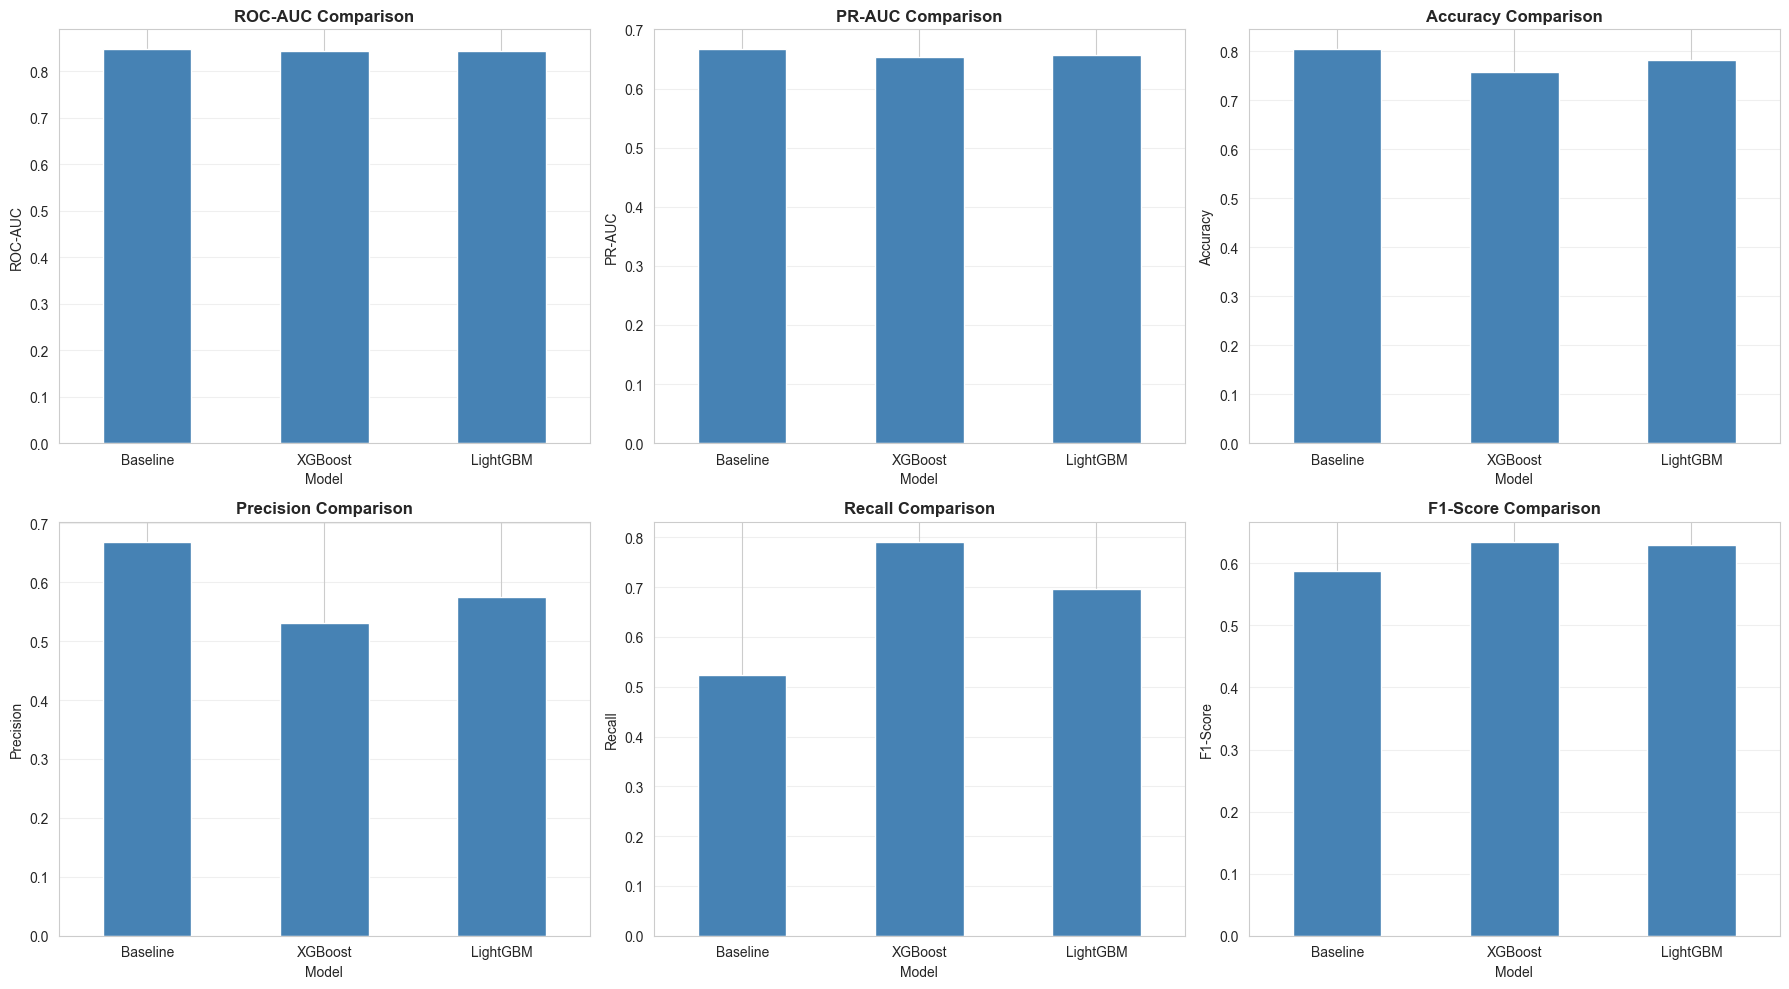


BEST MODEL IDENTIFIED

Best Model: Baseline (ROC-AUC: 0.8481)

[OK] Model comparison completed successfully


In [8]:
# Compare all models (only include models that were successfully trained)
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print("\nCollecting model performance metrics...")
models_to_compare = [("Baseline", baseline_metrics)]
if xgboost_metrics is not None:
    models_to_compare.append(("XGBoost", xgboost_metrics))
if lightgbm_metrics is not None:
    models_to_compare.append(("LightGBM", lightgbm_metrics))

comparison_data = {
    "Model": [name for name, _ in models_to_compare],
    "ROC-AUC": [m.roc_auc for _, m in models_to_compare],
    "PR-AUC": [m.pr_auc for _, m in models_to_compare],
    "Accuracy": [m.accuracy for _, m in models_to_compare],
    "Precision": [m.precision for _, m in models_to_compare],
    "Recall": [m.recall for _, m in models_to_compare],
    "F1-Score": [m.f1 for _, m in models_to_compare],
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
print("\nGenerating comparison visualizations...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ["ROC-AUC", "PR-AUC", "Accuracy", "Precision", "Recall", "F1-Score"]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    comparison_df.plot(x="Model", y=metric, kind="bar", ax=ax, legend=False, color="steelblue")
    ax.set_title(f"{metric} Comparison", fontweight="bold")
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison_df["Model"], rotation=0)
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = comparison_df["ROC-AUC"].idxmax()
best_model_name = comparison_df.loc[best_model_idx, "Model"]
print("\n" + "=" * 80)
print("BEST MODEL IDENTIFIED")
print("=" * 80)
print(
    f"\nBest Model: {best_model_name} (ROC-AUC: {comparison_df.loc[best_model_idx, 'ROC-AUC']:.4f})"
)
print("\n[OK] Model comparison completed successfully")

## 7. Model Explainability with SHAP

Let's analyze the best model's behavior using SHAP values.


MODEL EXPLAINABILITY ANALYSIS

Analyzing Baseline model (Logistic Regression)
Note: Baseline models have limited SHAP support.
Showing feature coefficients instead.

Top 20 Most Important Features (by absolute coefficient):
                            Feature  Coefficient  Abs_Coefficient
             cat__Contract_Two year    -1.801634         1.801634
   cat__InternetService_Fiber optic     1.051004         1.051004
             cat__Contract_One year    -0.941793         0.941793
                        num__tenure    -0.534406         0.534406
           cat__tenure_bucket_49-60     0.471736         0.471736
            cat__OnlineSecurity_Yes    -0.434545         0.434545
           cat__tenure_bucket_61-72     0.425631         0.425631
             cat__MultipleLines_Yes     0.422383         0.422383
           cat__tenure_bucket_37-48     0.327375         0.327375
                 num__charges_ratio     0.321177         0.321177
cat__PaymentMethod_Electronic check     0.320977  

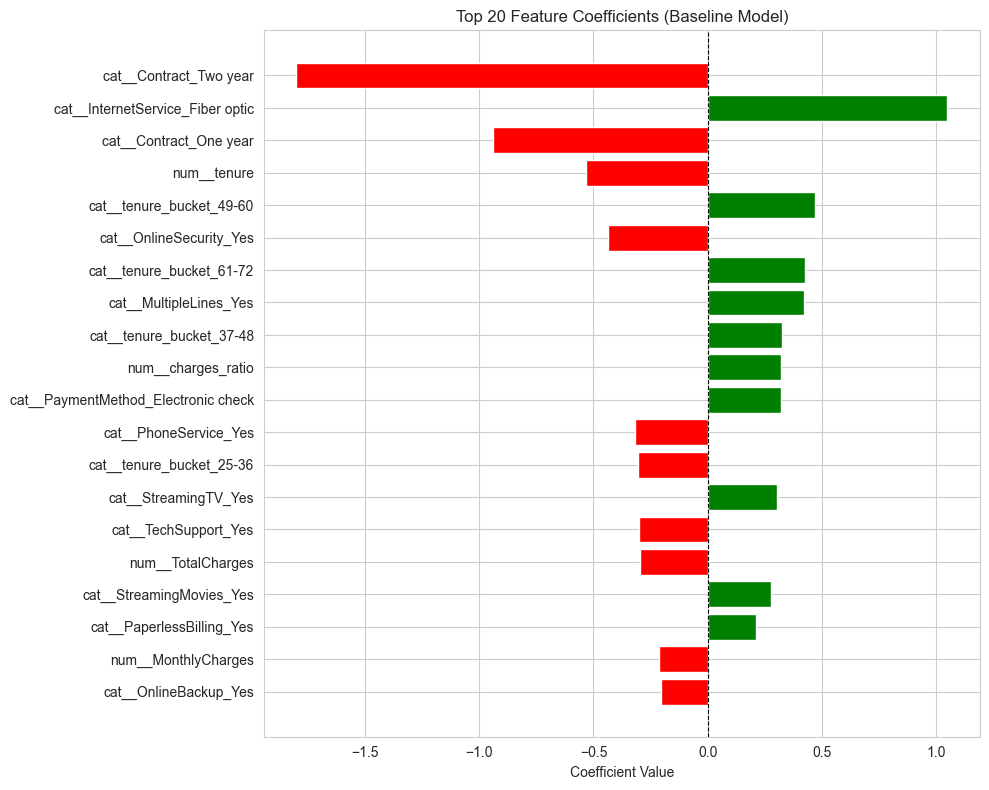


[OK] Feature coefficients displayed successfully

Interpretation:
  - Positive coefficients: Increase churn probability
  - Negative coefficients: Decrease churn probability
  - Larger absolute values: Stronger influence on prediction


In [9]:
# Select best model for explainability
print("=" * 80)
print("MODEL EXPLAINABILITY ANALYSIS")
print("=" * 80)

if best_model_name == "XGBoost":
    best_model = xgboost_model
    best_evaluator = xgboost_evaluator
    use_shap = True
elif best_model_name == "LightGBM":
    best_model = lightgbm_model
    best_evaluator = lightgbm_evaluator
    use_shap = True
else:
    best_model = baseline_model
    best_evaluator = baseline_evaluator
    use_shap = False  # Skip SHAP for baseline models (limited support)

# Handle explainability based on model type
if best_model_name == "Baseline":
    # For baseline models, show feature coefficients instead of SHAP
    print(f"\nAnalyzing {best_model_name} model (Logistic Regression)")
    print("Note: Baseline models have limited SHAP support.")
    print("Showing feature coefficients instead.\n")

    try:
        # Get the underlying logistic regression model
        lr_model = best_model.get_model()
        base_estimator = None

        # Handle CalibratedClassifierCV structure
        if hasattr(lr_model, "calibrated_classifiers_"):
            # If calibrated, get the base estimator from the first calibrated classifier
            if len(lr_model.calibrated_classifiers_) > 0:
                calibrated_clf = lr_model.calibrated_classifiers_[0]
                # CalibratedClassifierCV wraps the base estimator
                if hasattr(calibrated_clf, "estimator"):
                    base_estimator = calibrated_clf.estimator
                elif hasattr(calibrated_clf, "base_estimator"):
                    base_estimator = calibrated_clf.base_estimator
                else:
                    base_estimator = calibrated_clf
            else:
                # Fallback: try to get base_estimator directly
                if hasattr(lr_model, "base_estimator"):
                    base_estimator = lr_model.base_estimator
                else:
                    base_estimator = lr_model
        else:
            base_estimator = lr_model

        # Get coefficients
        if base_estimator is not None and hasattr(base_estimator, "coef_"):
            coefficients = base_estimator.coef_[0]

            # Verify coefficients match feature count
            if len(coefficients) != len(feature_names):
                print(
                    f"Warning: Coefficient count ({len(coefficients)}) doesn't match feature count ({len(feature_names)})"
                )
                # Use the minimum length to avoid index errors
                min_len = min(len(coefficients), len(feature_names))
                coefficients = coefficients[:min_len]
                feature_names_subset = feature_names[:min_len]
            else:
                feature_names_subset = feature_names

            # Create feature importance DataFrame
            feature_importance_df = pd.DataFrame(
                {
                    "Feature": feature_names_subset,
                    "Coefficient": coefficients,
                    "Abs_Coefficient": np.abs(coefficients),
                }
            ).sort_values("Abs_Coefficient", ascending=False)

            print("Top 20 Most Important Features (by absolute coefficient):")
            print(feature_importance_df.head(20).to_string(index=False))

            # Plot feature coefficients
            top_n = min(20, len(feature_importance_df))
            top_features = feature_importance_df.head(top_n)

            plt.figure(figsize=(10, 8))
            colors = ["red" if x < 0 else "green" for x in top_features["Coefficient"]]
            plt.barh(range(len(top_features)), top_features["Coefficient"], color=colors)
            plt.yticks(range(len(top_features)), top_features["Feature"])
            plt.xlabel("Coefficient Value")
            plt.title(f"Top {top_n} Feature Coefficients (Baseline Model)")
            plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            print("\n[OK] Feature coefficients displayed successfully")
            print("\nInterpretation:")
            print("  - Positive coefficients: Increase churn probability")
            print("  - Negative coefficients: Decrease churn probability")
            print("  - Larger absolute values: Stronger influence on prediction")
        else:
            print("Could not extract coefficients from model.")
            print(f"Model type: {type(base_estimator)}")
            print(
                f"Has coef_ attribute: {hasattr(base_estimator, 'coef_') if base_estimator is not None else 'N/A'}"
            )
    except Exception as e:
        print(f"Error extracting feature coefficients: {e}")
        print("Model structure may be different than expected.")
        import traceback

        traceback.print_exc()

elif SHAP_AVAILABLE and ModelExplainer is not None and use_shap:
    # For tree-based models, use SHAP
    print(f"\nAnalyzing {best_model_name} model with SHAP")
    try:
        # Convert DataFrames to numpy arrays for SHAP
        X_train_array = X_train_fit.values if hasattr(X_train_fit, "values") else X_train_fit
        X_test_array = X_test.values if hasattr(X_test, "values") else X_test

        # For tree models, SHAP will automatically use TreeExplainer
        print("Initializing SHAP explainer...")
        explainer = ModelExplainer(
            model=best_model,
            X_background=X_train_array[:1000],  # Sample for efficiency
            feature_names=feature_names,
        )

        # Generate explanation report
        print("\nGenerating SHAP values...")
        shap_values, summary = explainer.explain_batch(X_test_array[:500])  # Sample for efficiency

        # Plot feature importance
        print("Plotting feature importance...")
        explainer.plot_feature_importance(X_test_array[:500], top_n=20)
        plt.show()

        # Plot summary
        print("Plotting SHAP summary...")
        explainer.plot_summary(X_test_array[:500], max_display=20)
        plt.show()

        print("\n[OK] SHAP explanations generated successfully")
    except Exception as e:
        print(f"\n[FAIL] Error generating SHAP explanations: {e}")
        print(f"Error type: {type(e).__name__}")
        import traceback

        traceback.print_exc()
        print("\nSkipping SHAP explainability analysis.")

elif not SHAP_AVAILABLE:
    print("\nSHAP explainability is not available.")
    print("Install shap package to enable this feature: pip install shap")
else:
    print(f"\nExplainability analysis not available for {best_model_name} model.")

## 8. Evaluation Visualizations

Generate comprehensive evaluation plots for the best model.


GENERATING EVALUATION VISUALIZATIONS

Generating visualizations for best model: Baseline
Output directory: C:\Users\tiwar\OneDrive - The University of Melbourne\Desktop\New folder\telco-churn-retention\reports\modeling

1. Plotting ROC Curve...


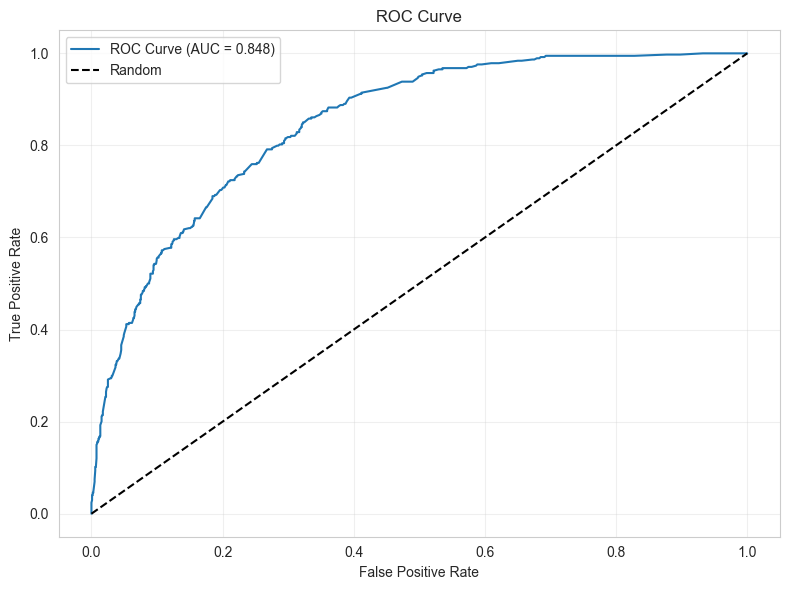

   [OK] ROC curve generated

2. Plotting Precision-Recall Curve...


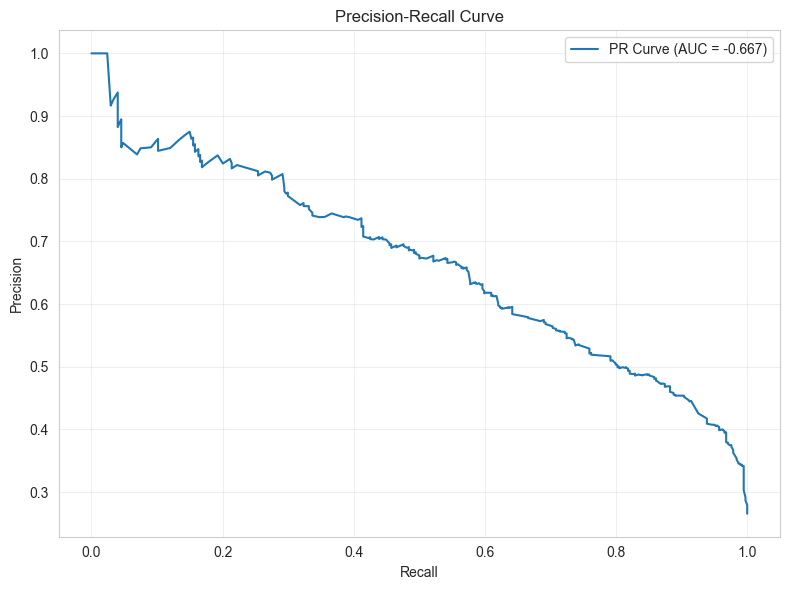

   [OK] PR curve generated

3. Plotting Calibration Curve...


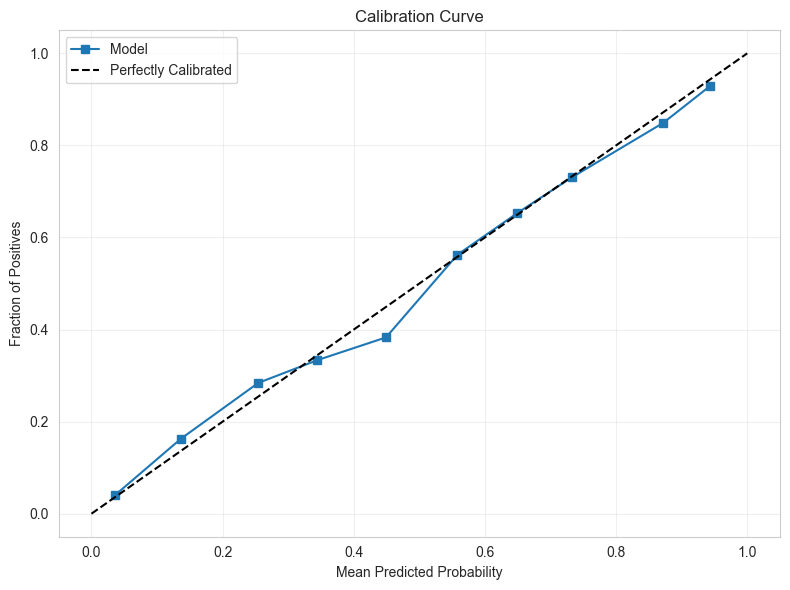

   [OK] Calibration curve generated

4. Plotting Confusion Matrix...


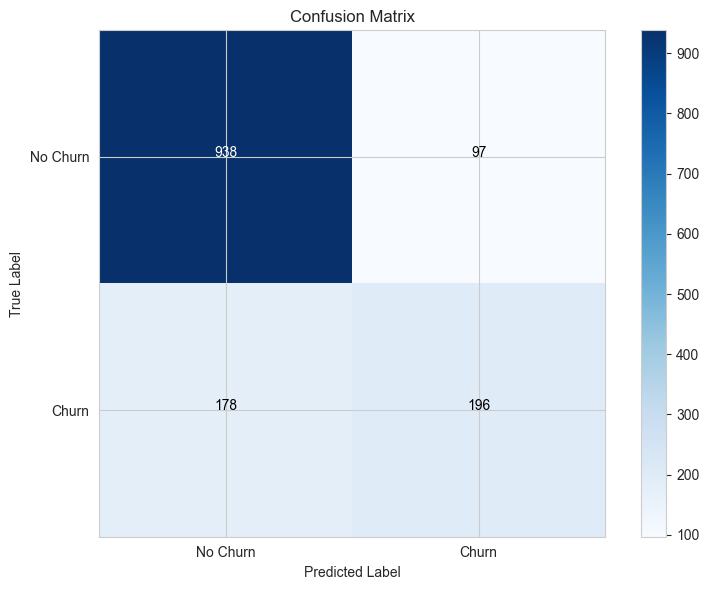

   [OK] Confusion matrix generated

EVALUATION VISUALIZATIONS COMPLETE

[OK] All evaluation visualizations generated successfully!


In [10]:
# Generate evaluation plots
print("=" * 80)
print("GENERATING EVALUATION VISUALIZATIONS")
print("=" * 80)

# Verify required variables are defined
if "best_model_name" not in globals():
    print(
        "\n[FAIL] ERROR: best_model_name not defined. Please run Cell 13 (Model Comparison) first."
    )
    raise NameError("best_model_name not defined. Run Cell 13 first.")

if "best_evaluator" not in globals():
    print("\n[FAIL] ERROR: best_evaluator not defined. Please run Cell 15 (Explainability) first.")
    raise NameError("best_evaluator not defined. Run Cell 15 first.")

if "X_test" not in globals() or "y_test" not in globals():
    print(
        "\n[FAIL] ERROR: X_test or y_test not defined. Please run Cell 5 (Train-Test Split) first."
    )
    raise NameError("X_test or y_test not defined. Run Cell 5 first.")

print(f"\nGenerating visualizations for best model: {best_model_name}")

output_dir = PROJECT_ROOT / "reports" / "modeling"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")

# Convert to numpy arrays for evaluation
X_test_array = X_test.values if hasattr(X_test, "values") else X_test
y_test_array = y_test.values if hasattr(y_test, "values") else y_test

try:
    print("\n1. Plotting ROC Curve...")
    # Get predictions for plotting
    y_pred_proba = best_evaluator.model.predict_proba(X_test_array)[:, 1]
    from sklearn.metrics import roc_auc_score, roc_curve

    fpr, tpr, _ = roc_curve(y_test_array, y_pred_proba)
    roc_auc = roc_auc_score(y_test_array, y_pred_proba)

    fig1 = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("   [OK] ROC curve generated")

    print("\n2. Plotting Precision-Recall Curve...")
    from sklearn.metrics import precision_recall_curve

    precision, recall, _ = precision_recall_curve(y_test_array, y_pred_proba)
    pr_auc = np.trapezoid(precision, recall)

    fig2 = plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("   [OK] PR curve generated")

    print("\n3. Plotting Calibration Curve...")
    from sklearn.calibration import calibration_curve

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_array, y_pred_proba, n_bins=10
    )

    fig3 = plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("   [OK] Calibration curve generated")

    print("\n4. Plotting Confusion Matrix...")
    from sklearn.metrics import confusion_matrix

    y_pred = (y_pred_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_test_array, y_pred)

    fig4 = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["No Churn", "Churn"])
    plt.yticks(tick_marks, ["No Churn", "Churn"])

    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
    print("   [OK] Confusion matrix generated")

    print("\n" + "=" * 80)
    print("EVALUATION VISUALIZATIONS COMPLETE")
    print("=" * 80)
    print("\n[OK] All evaluation visualizations generated successfully!")

except Exception as e:
    print(f"\n[FAIL] Error generating visualizations: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback

    traceback.print_exc()